
# Conversational RAG for STM data analysis

This notebook demonstrates a conversational RAG (Retrieval-Augmented Generation) agent designed to interface with custom STM data analysis code. 

Key features:
- **Chat history support**: The agent maintains context across multiple interactions, allowing users to refine queries and build upon previous responses
- **Code generation**: Generates executable Python code for STM data visualization and analysis
- **Interactive testing**: Generated code can be written to files and executed directly within the notebook for immediate validation
- **Database persistence**: Stores conversation history and generated code in SQLite for reproducibility

The workflow enables users to iteratively develop data analysis scripts through natural language interaction, with each response building on prior context and constraints.

# Imports and Functions

In [41]:
import os
import json
from pathlib import Path
from typing import List

from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

import uuid
import os
import json
from IPython import get_ipython

In [29]:

from langchain_classic.chains import create_retrieval_chain
from langchain_classic.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import MessagesPlaceholder
from langchain_classic.chains import create_history_aware_retriever

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

## Function for persist_db dir

In [30]:

from __future__ import annotations

import re
from pathlib import Path
from typing import Optional

def get_persist_dir(
    base_dir: str | Path,
    basename: str,
    *,
    new_persist: bool = False,
    create: bool = True,
) -> Path:
    """
    Find (or create) a persist directory under base_dir.

    Looks for directories named: f"{basename}_{run_id}" where run_id is an int.
    - If new_persist=False: returns the latest existing folder if found, else basename_0
    - If new_persist=True : returns a new folder with run_id = (latest + 1) or 0 if none exist
    """

    
    base_path = Path(base_dir).expanduser().resolve()
    base_path.mkdir(parents=True, exist_ok=True)

    pattern = re.compile(rf"^{re.escape(basename)}_(\d+)$")

    max_run_id: Optional[int] = None
    for p in base_path.iterdir():
        if not p.is_dir():
            continue
        m = pattern.match(p.name)
        if not m:
            continue
        run_id = int(m.group(1))
        if max_run_id is None or run_id > max_run_id:
            max_run_id = run_id

    if max_run_id is None:
        next_id = 0
    else:
        next_id = (max_run_id + 1) if new_persist else max_run_id

    persist_path = base_path / f"{basename}_{next_id}"

    if create:
        persist_path.mkdir(parents=True, exist_ok=True)

    return persist_path


## Load doc functions

In [31]:
def load_py_file(path: Path) -> Document:
    text = path.read_text(encoding="utf-8", errors="ignore")
    return Document(page_content=text, metadata={"source": str(path), "type": "py"})

def load_ipynb_file(path: Path) -> Document:
    nb = json.loads(path.read_text(encoding="utf-8", errors="ignore"))

    parts = []
    for cell in nb.get("cells", []):
        cell_type = cell.get("cell_type", "")
        src = cell.get("source", [])
        if isinstance(src, list):
            src = "".join(src)
        src = (src or "").strip()
        if not src:
            continue

        # Keep both markdown + code, but label them
        if cell_type == "code":
            parts.append("# --- notebook code cell ---\n" + src)
        elif cell_type == "markdown":
            parts.append("# --- notebook markdown cell ---\n" + src)

    text = "\n\n".join(parts)
    return Document(page_content=text, metadata={"source": str(path), "type": "ipynb"})

def load_code_documents(folder_path: str, exclude_filepaths = []) -> List[Document]:
    folder = Path(folder_path)
    documents: List[Document] = []

    
    exclude_set = set()
    if exclude_filepaths:
        for p in exclude_filepaths:
            if not p:  # skip None/"" just in case
                continue
            pp = Path(p)
            if pp.is_absolute():
                exclude_set.add(str(pp.resolve()))
            else:
                # allow both interpretations
                exclude_set.add(str((folder / pp).resolve()))  # relative to folder_path
                exclude_set.add(str(pp.resolve()))             # relative to cwd

    for path in folder.rglob("*"):
        if path.is_dir():
            continue

        if str(path.resolve()) in exclude_set:
            continue

        suffix = path.suffix.lower()
        if suffix == ".py":
            documents.append(load_py_file(path))
        elif suffix == ".ipynb":
            documents.append(load_ipynb_file(path))

    return documents

## RAG chain for single query

In [32]:


def get_rag_chain(folder_path: str, persist_basename: str, 
                  new_persist: bool = False, chunk_size: int = 1200, chunk_overlap: int = 200, 
                  model: str = "gpt-4o-mini", temperature: float = 0.0, api_key:str = None):
    
    """
        Create a RAG chain for code search and generation.
        
        Parameters
        ----------
        folder_path : str
            Path to the folder containing .py and .ipynb files to index
        persist_basename : str
            Base name for the persist directory (e.g., 'chroma_db_code')
        new_persist : bool, optional
            If True, create a new persist directory. If False, use existing one (default: False)
        chunk_size : int, optional
            Size of text chunks for splitting (default: 1200)
        chunk_overlap : int, optional
            Overlap between consecutive chunks (default: 200)
        model : str, optional
            OpenAI model name to use (default: 'gpt-4o-mini')
        temperature : float, optional
            Temperature for LLM responses (default: 0.0)
        api_key : Optional[str], optional
            OpenAI API key. If None, uses OPENAI_API_KEY environment variable (default: None)
        
        Returns
        -------
        rag_chain
            A LangChain runnable that takes a question and returns Python code
        """


    # -----------------------------
    # 1) Environment variables
    # -----------------------------
    # Make sure OPENAI_API_KEY is set in your environment before running
    if api_key is None:
        os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or ""
    else:
        os.environ["OPENAI_API_KEY"] = api_key

    print("OPENAI_API_KEY starts with:", (os.environ["OPENAI_API_KEY"][:5] + "...") if os.environ["OPENAI_API_KEY"] else "Not Set")

    # Disable LangSmith tracing (prevents 401 errors if you don't use LangSmith)
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    os.environ["LANGCHAIN_API_KEY"] = ""
    os.environ["LANGCHAIN_PROJECT"] = "rag-code-search"


    # -----------------------------
    # 2) Text splitting / chunking (tuned for code)
    # -----------------------------
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size= chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=["\n\n", "\n", " ", ""],
    )


    # -----------------------------
    # 3) Load .py and .ipynb from a folder
    # -----------------------------
    
    documents = load_code_documents(folder_path)
    print(f"Loaded {len(documents)} code documents from {folder_path!r} (.py + .ipynb).")

    splits = text_splitter.split_documents(documents)
    print(f"Split into {len(splits)} chunks.")


    # -----------------------------
    # 4) Embedding + Vector store (persisted)
    # -----------------------------
    #PERSIST_DIR = Path("./chroma_db_code_1")
    PERSIST_DIR = get_persist_dir("./persists/", persist_basename, new_persist=new_persist)


    COLLECTION_NAME = "code_collection"

    embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

    # IMPORTANT: if you run from_documents every time, you rebuild the DB.
    # The logic below loads existing DB if present, otherwise builds it.
    db_file = Path(PERSIST_DIR) / "chroma.sqlite3"
    if db_file.exists():
        vectorstore = Chroma(
            collection_name=COLLECTION_NAME,
            persist_directory=PERSIST_DIR,
            embedding_function=embedding_function,
        )
        print(f"Loaded existing vector DB from {PERSIST_DIR!r}.")
    else:
        if not splits:
            raise ValueError("No code chunks found. Check that ./docs contains .py or .ipynb files.")
        vectorstore = Chroma.from_documents(
            documents=splits,
            embedding=embedding_function,
            collection_name=COLLECTION_NAME,
            persist_directory=PERSIST_DIR,
        )
        #vectorstore.persist()
        print(f"Created and persisted vector DB at {PERSIST_DIR!r}.")


    # -----------------------------
    # 5) Retriever
    # -----------------------------
    #retriever = vectorstore.as_retriever(search_kwargs={"k": 6})
    retriever = vectorstore.as_retriever(
        search_type="mmr",
        search_kwargs={"k": 6, "fetch_k": 20, "lambda_mult": 0.5}
    )

    # -----------------------------
    # 6) RAG chain that outputs PYTHON CODE ONLY (as a string)
    # -----------------------------
    def docs2str(docs: List[Document]) -> str:
        # Keep source hints so the model can reference repo utilities if they exist
        out = []
        for d in docs:
            src = d.metadata.get("source", "unknown")
            out.append(f"### SOURCE: {src}\n{d.page_content}")
        return "\n\n".join(out)

    template = """You are a coding assistant.

    You must write Python code ONLY (no markdown fences, no explanations).
    Your output must be a single Python script as plain text.

    CONTEXT (repository code snippets):
    {context}

    Task:
    {question}

    Python code:"""

    prompt = ChatPromptTemplate.from_template(template)

    llm = ChatOpenAI(model=model, temperature=temperature)

    rag_chain = (
        {"context": retriever | docs2str, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

    return rag_chain


## QA rag chain function

In [33]:

def get_qa_rag_chain(folder_path: str, persist_basename: str, 
                  new_persist: bool = False, chunk_size: int = 1200, chunk_overlap: int = 200, 
                  model: str = "gpt-4o-mini", temperature: float = 0.0, api_key:str = None):
    

    """
        Create a conversational QA RAG chain with chat history support.
        
        Parameters  
        ----------
        folder_path : str
            Path to the folder containing .py and .ipynb files to index
        persist_basename : str
            Base name for the persist directory (e.g., 'chroma_db_code')
        new_persist : bool, optional
            If True, create a new persist directory. If False, use existing one (default: False)
        chunk_size : int, optional
            Size of text chunks for splitting (default: 1200)
        chunk_overlap : int, optional
            Overlap between consecutive chunks (default: 200)
        model : str, optional
            OpenAI model name to use (default: 'gpt-4o-mini')
        temperature : float, optional
            Temperature for LLM responses (default: 0.0)
        api_key : Optional[str], optional
            OpenAI API key. If None, uses OPENAI_API_KEY environment variable (default: None)
        
        Returns
        -------
        rag_chain
            A LangChain runnable that takes input and chat_history and returns an answer with context
        """



    # -----------------------------
    # 1) Environment variables
    # -----------------------------
    # Make sure OPENAI_API_KEY is set in your environment before running
    if api_key is None:
        os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or ""
    else:
        os.environ["OPENAI_API_KEY"] = api_key

    print("OPENAI_API_KEY starts with:", (os.environ["OPENAI_API_KEY"][:5] + "...") if os.environ["OPENAI_API_KEY"] else "Not Set")

    # Disable LangSmith tracing (prevents 401 errors if you don't use LangSmith)
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    os.environ["LANGCHAIN_API_KEY"] = ""
    os.environ["LANGCHAIN_PROJECT"] = "rag-code-search"


    # -----------------------------
    # 2) Text splitting / chunking (tuned for code)
    # -----------------------------
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size= chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=["\n\n", "\n", " ", ""],
    )


    # -----------------------------
    # 3) Load .py and .ipynb from a folder
    # -----------------------------

    documents = load_code_documents(folder_path)
    print(f"Loaded {len(documents)} code documents from {folder_path!r} (.py + .ipynb).")

    splits = text_splitter.split_documents(documents)
    print(f"Split into {len(splits)} chunks.")


    # -----------------------------
    # 4) Embedding + Vector store (persisted)
    # -----------------------------
    #PERSIST_DIR = Path("./chroma_db_code_1")
    PERSIST_DIR = get_persist_dir("./persists/", persist_basename, new_persist=new_persist)


    COLLECTION_NAME = "code_collection"

    embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

    # IMPORTANT: if you run from_documents every time, you rebuild the DB.
    # The logic below loads existing DB if present, otherwise builds it.
    db_file = Path(PERSIST_DIR) / "chroma.sqlite3"
    if db_file.exists():
        vectorstore = Chroma(
            collection_name=COLLECTION_NAME,
            persist_directory=PERSIST_DIR,
            embedding_function=embedding_function,
        )
        print(f"Loaded existing vector DB from {PERSIST_DIR!r}.")
    else:
        if not splits:
            raise ValueError("No code chunks found. Check that ./docs contains .py or .ipynb files.")
        vectorstore = Chroma.from_documents(
            documents=splits,
            embedding=embedding_function,
            collection_name=COLLECTION_NAME,
            persist_directory=PERSIST_DIR,
        )
        #vectorstore.persist()
        print(f"Created and persisted vector DB at {PERSIST_DIR!r}.")


    # -----------------------------
    # 5) Retriever
    # -----------------------------
    #retriever = vectorstore.as_retriever(search_kwargs={"k": 6})
    retriever = vectorstore.as_retriever(
        search_type="mmr",
        search_kwargs={"k": 6, "fetch_k": 20, "lambda_mult": 0.5}
    )

    # -----------------------------
    # 6) RAG chain that outputs PYTHON CODE ONLY (as a string)
    # -----------------------------
    def docs2str(docs: List[Document]) -> str:
        # Keep source hints so the model can reference repo utilities if they exist
        out = []
        for d in docs:
            src = d.metadata.get("source", "unknown")
            out.append(f"### SOURCE: {src}\n{d.page_content}")
        return "\n\n".join(out)

    
    llm = ChatOpenAI(model=model, temperature=temperature)

    # -----------------------------
    # 7 Query prompt (history -> standalone retrieval query)
    # -----------------------------
    contextualize_q_system_prompt = """
    You are a query rewriting assistant for retrieval.

    Given the chat history and the user's latest question:
    - Rewrite the question into a standalone search query that can be used to retrieve relevant code/docs.
    - Resolve references like "it", "that", "the previous one", etc. using the chat history.
    - Preserve exact identifiers (function names, class names, file paths, error messages, config keys).
    - Do NOT answer the question. Only output the rewritten query.
    - If the question is already standalone, return it unchanged.
    """.strip()

    contextualize_q_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", contextualize_q_system_prompt),
            MessagesPlaceholder("chat_history"),
            ("human", "{input}"),
        ]
    )


    history_aware_retriever = create_history_aware_retriever(
        llm=llm,
        retriever=retriever,
        prompt=contextualize_q_prompt,
    )


    # -----------------------------
    # 8) Answer prompt (use retrieved docs + chat history)
    # -----------------------------
    qa_system_prompt = """
    You are a helpful assistant.

    Use BOTH:
    - The retrieved context (primary source of truth).
    - The chat history (to understand intent, constraints, and resolve references).

    Rules:
    - Output only the python code as a single script, such the user can run it directly. Do not add ```python``` markers
    - If using explanations or markdown text, comment them.
    - Prefer the retrieved context for factual claims about the code/docs.
    - Use chat history mainly to interpret what the user means and what constraints they set earlier.
    - If the retrieved context does not contain the answer, say so clearly and suggest what to search for next.
    """.strip()

    qa_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", qa_system_prompt),
            MessagesPlaceholder("chat_history"),
            ("human", "Question: {input}\n\nRetrieved context:\n{context}"),
        ]
    )

    question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

    # -----------------------------
    # 9) Full RAG chain
    # -----------------------------
    rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)


    return rag_chain

## DB connection functions

In [35]:
import sqlite3
from datetime import datetime

DB_NAME = "rag_chat_logs.db"

def get_db_connection():
    """
    Return a connection to the SQLite database.
    Sets row_factory to sqlite3.Row for dict-like access.
    """
    
    conn = sqlite3.connect(DB_NAME)
    conn.row_factory = sqlite3.Row
    return conn

def create_application_logs():

    """
    Create the application_logs table if it doesn't exist.
        
        This table stores:
        - session_name: session theme or unique identifier for a chat session
        - user_query: the question/prompt from the user
        - ai_response: the generated code/answer from the model
        - model_name: the model name used (e.g., 'gpt-4o-mini')
        - created_at: timestamp of when the log was created
    """

    conn = get_db_connection()
    conn.execute('''CREATE TABLE IF NOT EXISTS application_logs
                    (id INTEGER PRIMARY KEY AUTOINCREMENT,
                     session_name TEXT,
                     user_query TEXT,
                     ai_response TEXT,
                     model_name TEXT,
                     created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP)''')
    conn.close()


def insert_application_logs(session_name, user_query, ai_response, model_name):
      
    """
    Insert a new log entry into the application_logs table.
    
    Parameters:
    - session_name: The name or identifier of the chat session
    - user_query: The user's input or question
    - ai_response: The AI's generated response
    - model_name: The name of the model used to generate the response
    """


    conn = get_db_connection()
    conn.execute('INSERT INTO application_logs (session_name, user_query, ai_response, model_name) VALUES (?, ?, ?, ?)',
                 (session_name, user_query, ai_response, model_name))
    conn.commit()
    conn.close()


def get_chat_history(session_name):

    """
    Retrieve chat history for a given session from the application_logs table.

    Parameters:
    - session_name: The name or identifier of the chat session

    Returns:
    - List of HumanMessage and AIMessage objects representing the chat history
    """
    conn = get_db_connection()
    cursor = conn.cursor()
    cursor.execute('SELECT user_query, ai_response FROM application_logs WHERE session_name = ? ORDER BY created_at', (session_name,))
    chat_history = []
    for row in cursor.fetchall():
        chat_history.extend([
        HumanMessage(content=row['user_query']),
        AIMessage(content=row['ai_response'])
])
    conn.close()

    return chat_history



# Initialize the database
create_application_logs()

## Write code to py-file

In [36]:

def write_generated_code_to_file(
    code_str: str,
    filename: str = "main_rag_test.py",
    encoding: str = "utf-8",
) -> Path:
    """
    Overwrite `filename` with `code_str`. Creates the file if it doesn't exist.
    Returns the Path to the written file.
    """
    path = Path(filename).expanduser().resolve()
    path.parent.mkdir(parents=True, exist_ok=True)

    # Ensure we're writing a string (some chains return dicts / messages)
    if not isinstance(code_str, str):
        code_str = str(code_str)

    # Add a trailing newline for nicer diffs/editors
    if not code_str.endswith("\n"):
        code_str += "\n"

    path.write_text(code_str, encoding=encoding)
    return path

## Execute code.

In [47]:
# def execute_code_file(pyfile_name: str):
#     """Execute the Python code in the specified file."""
#     pth = Path(pyfile_name)
#     if not pth.exists() or not pth.is_file():
#         raise ValueError(f"Python file {pyfile_name} does not exist or is not a file.")
    
#     %matplotlib inline
#     output = %run {pyfile_name}
    
#     return output


def execute_code_file(pyfile_name: str):
    """Run a .py file in the current IPython kernel (so inline plots display in notebooks)."""
    pth = Path(pyfile_name)
    if not pth.exists() or not pth.is_file():
        raise ValueError(f"Python file {pyfile_name} does not exist or is not a file.")


    ip = get_ipython()
    if ip is None:
        raise RuntimeError("Not running inside IPython/Jupyter. Use 'python3 file.py' in a terminal instead.")

    # Ensure inline backend (safe if already set)
    ip.run_line_magic("matplotlib", "inline")

    # Run file like `%run -i file.py` (keeps variables in user namespace)
    ip.run_line_magic("run", f"-i {str(pth)}")

    # `%run` doesn't return a useful 'output' object; return the namespace dict instead
    return #ip.user_ns

# Coversational data analysis

Here we analyse the hyperspectral data in "./stm_data_code_sample/3D_hyperspectral_data"

In [53]:
new_persist = False # Set to True to create a new persist directory. Set to True while creating new db.
folder_path = "./stm_data_code_sample/3D_hyperspectral_data"

# Chunk size and overlap hyperparameters
chunk_size = 1200
chunk_overlap = 200


api_key = os.getenv("OPENAI_API_KEY")
persist_basename = "chroma_db_code3d"

model = "gpt-5"
temperature = 0  #Vary in the range 0-2.

rag_chain = get_qa_rag_chain(
    folder_path=folder_path,
    persist_basename=persist_basename,
    new_persist=new_persist,
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    model=model,
    temperature=temperature,
    api_key=api_key,
)



OPENAI_API_KEY starts with: sk-pr...
Loaded 2 code documents from './stm_data_code_sample/3D_hyperspectral_data' (.py + .ipynb).
Split into 7 chunks.
Loaded existing vector DB from WindowsPath('C:/Users/ggn/1_py_scripts/RAG/RAG_data_analysis_hackathon_2025/persists/chroma_db_code3d_9').


## chat1

In [58]:
session_theme = "analyse_hyperspectral_data1"

if session_theme is None or session_theme.strip() == "":
    session_theme = str(uuid.uuid4())  # Generate a new session ID if not provided

chat_history = get_chat_history(session_theme)
print("chat_history:", chat_history)
task1 = """
Write code to plot the current map at a probe bias of 1.2 V for the cits_data.3ds".
- Import necessary libraries
- The script should:
  1) load ./stm_data_code_sample/3D_hyperspectral_data/cits_data.3ds
  2) extract the Z/height channel (or the most appropriate topography channel)
  3) plot it with matplotlib imshow + colorbar
  4) Do not save the image to file, just show it
"""

answer1 = rag_chain.invoke({"input": task1, "chat_history":chat_history})['answer']
insert_application_logs(session_theme, task1, answer1, model)
print(f"Human: {task1}")
print(f"\n===== AI GENERATED PYTHON CODE (STRING) =====\n{answer1}\n")

chat_history: []
Human: 
Write code to plot the current map at a probe bias of 1.2 V for the cits_data.3ds".
- Import necessary libraries
- The script should:
  1) load ./stm_data_code_sample/3D_hyperspectral_data/cits_data.3ds
  2) extract the Z/height channel (or the most appropriate topography channel)
  3) plot it with matplotlib imshow + colorbar
  4) Do not save the image to file, just show it


===== AI GENERATED PYTHON CODE (STRING) =====
import numpy as np
import matplotlib.pyplot as plt

# If stmpy is not installed, install it with: pip install stmpy
import stmpy

# --- Load the data ---
filepath = "./stm_data_code_sample/3D_hyperspectral_data/cits_data.3ds"
smd = stmpy.load(filepath, biasOffset=False)

# --- Helper to extract a topography (Z/height) map ---
def extract_topography_2d(smd_obj):
    """
    Try to find a topography-like 2D map from the loaded .3ds object.
    Returns (topo_2d, label) if found, else (None, None).
    """
    # Direct attributes some datasets may

### Test code

Write the code to "main_rag_test.py". Overwrites if already exists.

Test it by running "python main_rag_test.py" on terminal.

File import successful.
Topography (Z/height) channel not found in this .3ds file.
Tip: inspect available channels via: print(smd.grid.keys())


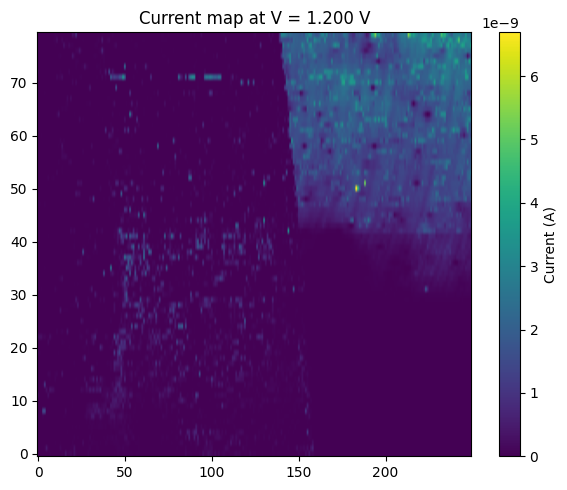

<Figure size 640x480 with 0 Axes>

In [59]:
write_generated_code_to_file(answer1, "main_rag_test.py")
execute_code_file("main_rag_test.py")

## Chat 2

In [60]:
chat_history = get_chat_history(session_theme)
print("chat_history:", chat_history)
task2 = "can you plot a similar didv_x map at 1.5 V? Keep the imports consistent with the previous code. " \
"Assume code is executed from the current directory. "

answer2 = rag_chain.invoke({"input": task2, "chat_history":chat_history})['answer']
insert_application_logs(session_theme, task2, answer2, model)
print(f"Human: {task2}")
print(f"\n===== AI GENERATED PYTHON CODE (STRING) =====\n\n{answer2}\n")

chat_history: [HumanMessage(content='\nWrite code to plot the current map at a probe bias of 1.2 V for the cits_data.3ds".\n- Import necessary libraries\n- The script should:\n  1) load ./stm_data_code_sample/3D_hyperspectral_data/cits_data.3ds\n  2) extract the Z/height channel (or the most appropriate topography channel)\n  3) plot it with matplotlib imshow + colorbar\n  4) Do not save the image to file, just show it\n', additional_kwargs={}, response_metadata={}), AIMessage(content='import numpy as np\nimport matplotlib.pyplot as plt\n\n# If stmpy is not installed, install it with: pip install stmpy\nimport stmpy\n\n# --- Load the data ---\nfilepath = "./stm_data_code_sample/3D_hyperspectral_data/cits_data.3ds"\nsmd = stmpy.load(filepath, biasOffset=False)\n\n# --- Helper to extract a topography (Z/height) map ---\ndef extract_topography_2d(smd_obj):\n    """\n    Try to find a topography-like 2D map from the loaded .3ds object.\n    Returns (topo_2d, label) if found, else (None, No

### Test code

Write the code to "main_rag_test.py". Overwrites if already exists.

Test it by running "python main_rag_test.py" on terminal.

File import successful.


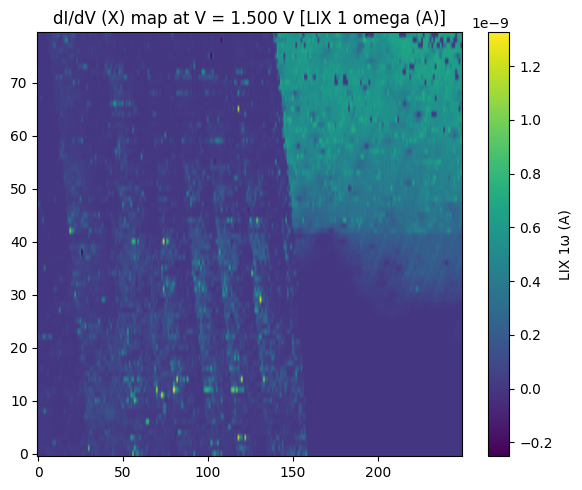

<Figure size 640x480 with 0 Axes>

In [61]:
write_generated_code_to_file(answer2, "main_rag_test.py")
execute_code_file("main_rag_test.py")


# chat3

In [62]:

chat_history = get_chat_history(session_theme)
task3 = "Great. Now provide the (didv_x vs V) plot at the at the point (2E-7, 2E-7)"
answer3 = rag_chain.invoke({"input": task3, "chat_history":chat_history})['answer']
insert_application_logs(session_theme, task3, answer3, model)
print(f"Human: {task3}")
print(f"\n===== AI GENERATED PYTHON CODE (STRING) =====\n\n{answer3}\n")

Human: Great. Now provide the (didv_x vs V) plot at the at the point (2E-7, 2E-7)

===== AI GENERATED PYTHON CODE (STRING) =====

import numpy as np
import matplotlib.pyplot as plt

# If stmpy is not installed, install it with: pip install stmpy
import stmpy
import re

# --- Load the data ---
filepath = "./stm_data_code_sample/3D_hyperspectral_data/cits_data.3ds"
smd = stmpy.load(filepath, biasOffset=False)

# --- Helper to find a didv_x (LIX) channel in the grid ---
def find_didv_x_array(smd_obj):
    """
    Return the (nV, Ny, Nx) array for the dI/dV X channel if present.
    Tries common STMPy keys like 'LIX 1 omega (A)'.
    """
    if not hasattr(smd_obj, "grid") or not isinstance(smd_obj.grid, dict):
        return None, None

    priority_keys = [
        "LIX 1 omega (A)",
        "LIX (A)",
        "LI X 1 omega (A)",
        "LIX",
    ]

    for k in priority_keys:
        if k in smd_obj.grid:
            arr = smd_obj.grid[k]
            if isinstance(arr, np.ndarray) and

### Test the code
Write the code to "main_rag_test.py". Overwrites if already exists.

Test it by running "python main_rag_test.py" on terminal.

File import successful.


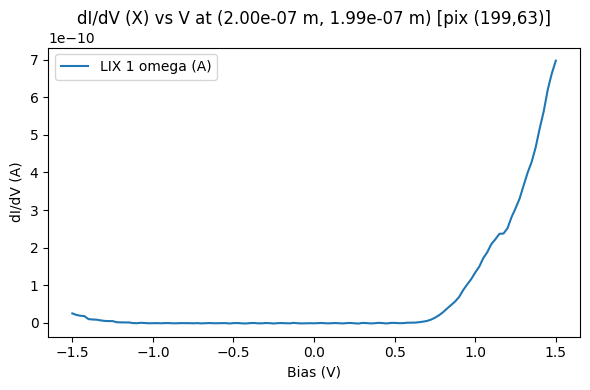

<Figure size 640x480 with 0 Axes>

In [65]:
write_generated_code_to_file(answer3, "main_rag_test.py")
execute_code_file("main_rag_test.py")